In [1]:
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plot_config
from sklearn.metrics import cohen_kappa_score, accuracy_score
from imblearn.metrics import geometric_mean_score
plot_config.set_config()

In [2]:
experiment = 'powersupply'
name_caps = 'PowerSupply'

In [3]:
off_scores = load('../data/'+experiment+'/off_scores.joblib')
off_preds = load('../data/'+experiment+'/off_preds.joblib')
off_targets = load('../data/'+experiment+'/off_targets.joblib')

In [4]:
kappas = []
gmeans = []
accurs = []
for i in range(100):
    scores = off_scores[300+i:300+i+10]
    app = [i for i,(x,y) in enumerate(scores) if abs(x-y)>0.1]
    preds = off_preds[i][app]
    targets = off_targets[i][app]
    
    if not np.isnan(geometric_mean_score(targets, preds)):
        gmeans.append(geometric_mean_score(targets, preds))
        
    if not np.isnan(accuracy_score(targets, preds)):
        accurs.append(accuracy_score(targets, preds))
        
    if np.array_equal(preds, targets):
        kappas.append(1.0)
    else:
        kappas.append(cohen_kappa_score(targets, preds))
print(np.mean(kappas), "+-", np.std(kappas))
print(np.mean(gmeans), "+-", np.std(gmeans))
print(np.mean(accurs), "+-", np.std(accurs))

0.3083214334684923 +- 0.476798685701107
0.3642973751246978 +- 0.44790708390311107
0.5314236111111111 +- 0.3639885608167905


/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/scipy/stats/stats.py:411: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))
/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


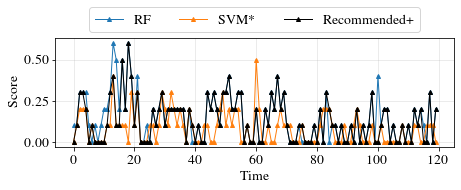

In [5]:
rf_score = load('../data/'+experiment+'/score_rf.joblib')[:120]
svm_score = load('../data/'+experiment+'/score_svm.joblib')[:120]
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))[:120]
fig = plt.gcf()
fig.set_size_inches(7.14, 2)
plt.plot(rf_score, '^-', label='RF')
plt.plot(svm_score, '^-', label='SVM*')
plt.plot(score_recommended, 'k^-', label='Recommended+')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True)
plt.savefig(experiment+'_tscores.pdf', bbox_inches='tight')

In [6]:
t_importance = load('../data/'+experiment+'/importance.joblib')
t_fname = load('../data/'+experiment+'/fnames.joblib')[:-1]
dic = sorted([(k,v) for k,v in zip(t_importance, t_fname)])[-15:]
importance = [k for k,v in dic]
fname = [v for k,v in dic]
pos = np.arange(len(importance))

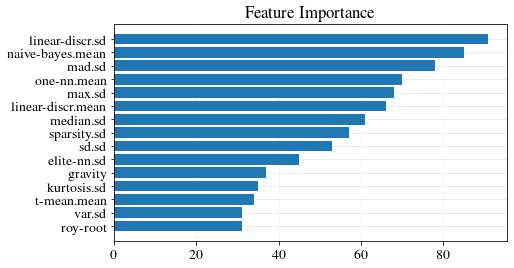

In [7]:
fig, ax1 = plt.subplots()
fig.subplots_adjust(left=0.115, right=0.88)
ax1.set_title('Feature Importance')
ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
rects = plt.barh(pos, importance,
         align='center',
         tick_label=[x.replace('_','-') for x in fname])
fig = plt.gcf()
fig.set_size_inches(7.14, 4)
plt.savefig(experiment+'_fi.pdf', bbox_inches='tight')

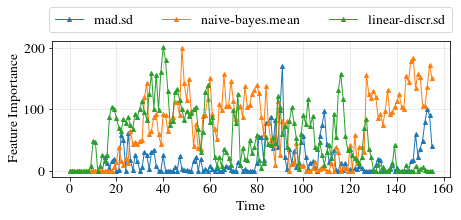

In [8]:
tfi = load('../data/'+experiment+'_ninc/tfi.joblib')
topfname = fname[-3:]
tfi = pd.DataFrame(tfi, columns=t_fname)[topfname]
tfi.rename(columns={x:x.replace('_','-') for x in topfname}, inplace=True)
ax = tfi.plot(style='^-')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3, fancybox=True)
fig = plt.gcf()
fig.set_size_inches(7.14, 2.5)
plt.savefig(experiment+'_timefi.pdf', bbox_inches='tight')

In [9]:
arange = 1000
difference = np.array(load('../data/'+experiment+'/difference.joblib'))
difference_ninc = np.array(load('../data/'+experiment+'_ninc/difference.joblib'))
cum = np.cumsum(difference)[:arange]
cum_ninc = np.cumsum(difference_ninc)[:arange]
x = np.arange(arange)

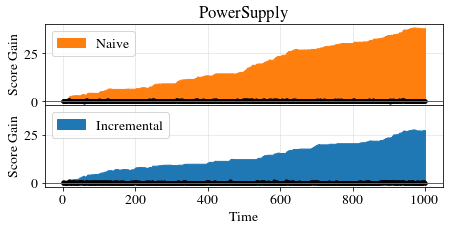

In [10]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

ax1.fill_between(x, cum_ninc, 0, color='C1', label='Naive')
ax1.scatter(x, difference_ninc[:arange], s=10, c='black')
ax1.set_title(name_caps)
ax1.axhline(0)
ax1.legend(loc='upper left')
ax1.set_ylabel('Score Gain')

ax2.fill_between(x, cum, 0, color='C0', label='Incremental')
ax2.scatter(x, difference[:arange], s=10, c='black')
ax2.axhline(0)
ax2.legend(loc='upper left')
ax2.set_ylabel('Score Gain')
ax2.set_xlabel('Time')

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_cumsum.pdf', bbox_inches='tight')

In [11]:
print(cum[-10:])

[27.  27.2 27.2 27.3 27.2 27.1 27.3 27.4 27.4 27.2]


In [12]:
with open('../'+experiment.replace('_','-')+'.output') as fin:
    print(fin.read())


  0%|          | 0/2 [00:00<?, ?it/s][FINETUNING BASE MODELS]

100%|██████████| 2/2 [05:48<00:00, 174.27s/it]

100%|██████████| 400/400 [08:38<00:00,  1.30s/it]

 98%|█████████▊| 98/100 [23:39<00:15,  7.70s/it] * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

 99%|█████████▉| 99/100 [23:40<00:05,  5.72s/it] * Warning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

100%|██████████| 100/100 [23:40<00:00, 14.21s/it]
[GENERATE METAFEATURE]
Frequency statistics in metabase:
	Pipeline                 0.535
	RandomForestClassifier   0.465
[OFFLINE LEARNING]



In [13]:
metadf = load('../data/'+experiment+'/metadf.joblib')
best = np.array(load('../data/'+experiment+'/best.joblib'))
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))
score_default = np.array(load('../data/'+experiment+'/score_def.joblib'))


score_recommended_ninc = np.array(load('../data/'+experiment+'_ninc/score_reco.joblib'))
score_default_ninc = np.array(load('../data/'+experiment+'_ninc/score_def.joblib'))

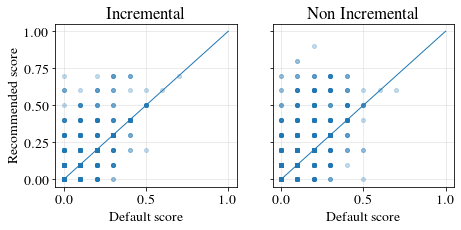

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

ax1.scatter(score_default, score_recommended, alpha=.25)
ax1.set_ylabel('Recommended score')
ax1.set_title('Incremental')
ax1.set_xlabel('Default score')
ax1.plot([0,1])

ax2.scatter(score_default_ninc, score_recommended_ninc, alpha=.25)
ax2.set_title('Non Incremental')
ax2.set_xlabel('Default score')
ax2.plot([0,1])

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_score.pdf', bbox_inches='tight')